In [1]:
using Graphs
using Printf
using DataFrames
using CSV
using SpecialFunctions
using LinearAlgebra
using TikzGraphs

## Code

In [2]:
const Assignment = Dict{Symbol,Int}
const FactorTable = Dict{Assignment,Float64}
struct Variable
    name::Symbol
    r::Int # number of possible values
end

struct Factor
    vars::Vector{Variable}
    table::FactorTable
end

struct BayesianNetwork
    vars::Vector{Variable}
    factors::Vector{Factor}
    graph::SimpleDiGraph{Int64}
end

struct K2Search
    ordering::Vector{Int} # variable ordering
end

In [3]:
function sub2ind(siz, x)
    k = vcat(1, cumprod(siz[1:end-1]))
    return dot(k, x .- 1) + 1
end

function statistics(vars, G, D::Matrix{Int})
    n = size(D, 1)
    r = [vars[i].r for i in 1:n]
    q = [prod([r[j] for j in inneighbors(G,i)]) for i in 1:n]
    M = [zeros(q[i], r[i]) for i in 1:n]
    for o in eachcol(D)
        for i in 1:n
            k = o[i]
            parents = inneighbors(G,i)
            j = 1
            if !isempty(parents)
                 j = sub2ind(r[parents], o[parents])
            end
            M[i][j,k] += 1.0
        end
    end
    return M
end

function prior(vars, G)
    n = length(vars)
    r = [vars[i].r for i in 1:n]
    q = [prod([r[j] for j in inneighbors(G,i)]) for i in 1:n]
    return [ones(q[i], r[i]) for i in 1:n]
end

prior (generic function with 1 method)

In [4]:
function bayesian_score_component(M, alpha)
    p =  sum(loggamma.(alpha + M))
    p -= sum(loggamma.(alpha))
    p += sum(loggamma.(sum(alpha,dims=2)))
    p -= sum(loggamma.(sum(alpha,dims=2) + sum(M,dims=2)))
    return p
end

function bayesian_score(vars, G, D)
    n = length(vars)
    M = statistics(vars, G, D)
    alpha = prior(vars, G)
    return sum(bayesian_score_component(M[i], alpha[i]) for i in 1:n)
end

bayesian_score (generic function with 1 method)

In [5]:
function fit(method::K2Search, vars, D)
    G = SimpleDiGraph(length(vars))
    for (k,i) in enumerate(method.ordering[2:end])
        y = bayesian_score(vars, G, D)
        while true
            y_best, j_best = -Inf, 0
            for j in method.ordering[1:k]
                if !has_edge(G, j, i)
                    add_edge!(G, j, i)
                    y_p = bayesian_score(vars, G, D)
                    if y_p > y_best
                        y_best, j_best = y_p, j
                    end
                    rem_edge!(G, j, i)
                end
            end
            if y_best > y
                y = y_best
                add_edge!(G, j_best, i)
            else
                break
            end
        end
    end
    return G
end

fit (generic function with 1 method)

In [10]:
function write_gph(dag::DiGraph, idx2names, filename)
    open(filename, "w") do io
        for edge in edges(dag)
            @printf(io, "%s,%s\n", idx2names[src(edge)], idx2names[dst(edge)])
        end
    end
end


function compute(infile, outfile, max_values)

    # WRITE YOUR CODE HERE
    # FEEL FREE TO CHANGE ANYTHING ANYWHERE IN THE CODE
    # THIS INCLUDES CHANGING THE FUNCTION NAMES, MAKING THE CODE MODULAR, BASICALLY ANYTHING
    df = DataFrame(CSV.File(infile))
    vars = []
    for name in names(df)
        push!(vars, Variable(Symbol(name), max_values))
    end
    idx2names = Dict(i => names(df)[i] for i=1:(size(names(df))[1]))
    ordering = 1:(size(vars)[1])
    G = fit(K2Search(ordering), vars, Matrix(Matrix(df)'))
    write_gph(G, idx2names, outfile)
    labels = String[]
    for var in vars
        push!(labels, String(var.name))
    end
    return G, labels
end

compute (generic function with 2 methods)

  0.142566 seconds (1.98 M allocations: 111.647 MiB, 14.68% gc time, 17.09% compilation time)


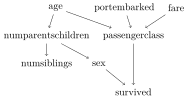

In [11]:
@time G_res, labels = compute("data/small.csv", "small.gph", 3)
TikzGraphs.plot(G_res, labels)

  2.674462 seconds (45.98 M allocations: 2.574 GiB, 16.09% gc time)


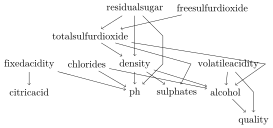

In [12]:
@time G_res, labels = compute("data/medium.csv", "medium.gph", 5)
TikzGraphs.plot(G_res, labels)

633.919700 seconds (11.46 G allocations: 746.050 GiB, 15.66% gc time)


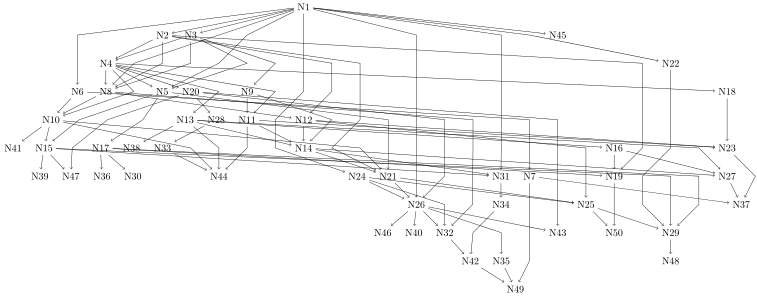

In [13]:
@time G_res, labels = compute("data/large.csv", "large.gph", 4)
TikzGraphs.plot(G_res, labels)